In [41]:
import numpy as np
import matplotlib.pyplot as plt
import batman

In [42]:
# Define some things we know
P_literature = 384.843
tau_literature = 54833 + 314.98
T_literature = 10.63/24.0      # literature reported transit duration

In [43]:
# Define a set of test parameters [use values from Jenkins+]
theta=np.empty([5])
theta[0] = 0.0128          # Rp/Rstar
theta[1] = 3.306           # log(rho* [kg/m3])
theta[2] = 0.69            # b impact parameter
theta[3] = P_literature    # orbital period
theta[4] = tau_literature  # transit mid-point

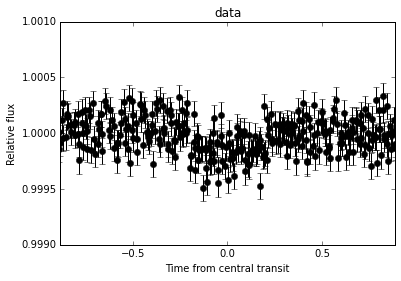

In [44]:
# Define a set of test times
#t = np.linspace(theta[0]-2.0*T_literature, theta[0]+2.0*T_literature, 1000)

data = np.genfromtxt("lightcurve.dat", dtype=None)
tobs=data[:,0]    # times of observations
fobs=data[:,1]    # relative fluxes
sigfobs=data[:,2] # errors on fluxes
tobsfolded=np.empty([len(tobs)])
for i in range(len(tobs)):
    tobsfolded[i]=tobs[i]-tau_literature-P_literature*np.round((tobs[i]-tau_literature)/P_literature)

%matplotlib inline

plt.figure()
plt.errorbar(tobsfolded, fobs, yerr=sigfobs,fmt='ko')
plt.title("data")
plt.xlabel('Time from central transit')
plt.ylabel('Relative flux')
plt.xlim(-2*T_literature,+2*T_literature)
plt.ylim(0.999,1.001)
plt.show()

In [45]:
# Set a definition for the model
def model(theta,times):
    Grv = 6.67408e-11
    impact = theta[2]
    logrho = theta[1]
    rhostar = np.power(10.0,logrho)
    aR = np.power( ( Grv*(theta[3]*86400.0)**2*rhostar )/( 3.0*np.pi ), 0.33333333 )
    incdeg = (180.0/np.pi)*np.arccos(impact/aR)
    # Initialize the Batman code
    params = batman.TransitParams()
    # Set the model parameters
    params.rp = theta[0]                #R_planet/R_star
    params.a = aR                       #a/R_star
    params.inc = incdeg                 #orbital inclination (degrees)
    params.per = theta[3]               #orbital period (days)
    params.t0 = theta[4]                #transit midpoint time (days)
    # These parameters are just kept fixed
    params.ecc = 0.0                    #eccentricity
    params.w = 90.                      #longitude of periastron (degrees)
    params.limb_dark = "quadratic"      #limb darkening model--other choices include quadratic, etc.
    # Coefficients for a nonlinear limb darkening law.
    params.u = [0.459196, 0.2248176]
    # Call the Batman code
    m = batman.TransitModel(params, times, supersample_factor=30, exp_time=0.020434)
    flux = m.light_curve(params) #calculate the flux
    return flux

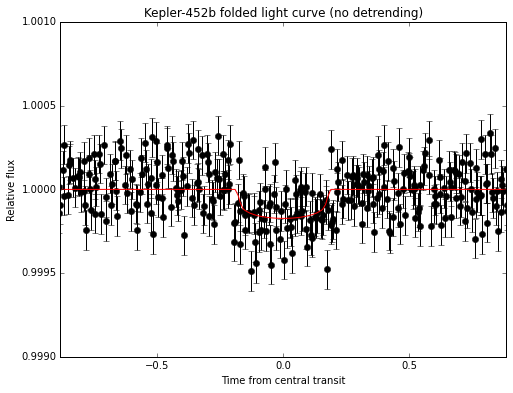

In [46]:
%matplotlib inline

theta[4]=0.0 # since I have folded the lightcurve, purely for the sake of visualization,
             # i am going to set tau=0 to give a nice plot
# since i'm going to do a continuous line for my model, i need to sort the times first
fmod = model(theta,np.sort(tobsfolded))

fig = plt.figure(figsize=(8,6))
plt.errorbar(tobsfolded, fobs, yerr=sigfobs,fmt='ko')
plt.plot(np.sort(tobsfolded), fmod, c='r')
plt.title('Kepler-452b folded light curve (no detrending)')
plt.xlabel('Time from central transit')
plt.ylabel('Relative flux')
plt.xlim(-2*T_literature,+2*T_literature)
plt.ylim(0.999,1.001)
plt.show()